In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV




rng_seed = 425
data = pd.read_csv('nurburgring_times.csv')
X = data[['horsepower (hp)', 'torque (lb-ft)', 'kerb weight (lb)', 'wheel base (in)', 'width (in)', 'height (in)', 'RWD', 'AWD', 'FWD', '0-60 (s)', 'top speed (mph)', 'manual', 'automatic']]
Y = data['time (s)']

In [2]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=rng_seed)

scaler = StandardScaler()
scaler.fit(X_train)
Scaled_Xtrain = scaler.transform(X_train)
Scaled_Xtest = scaler.transform(X_test)


In [3]:
def evalModel(prediction, modeltype):
    print('Mean squared error (MSE): %.2f' % mean_squared_error(Y_test, prediction))
    print('Coefficient of determination (R^2): %.2f' % r2_score(Y_test, prediction))
    
    plt.scatter(Y_test, prediction)
    plt.xlabel("Testing Lap Time (s)")
    plt.ylabel("Predicted Lap Time (s)")
    plt.title("Predicted vs Testing times using " + modeltype)
    plt.show()

In [4]:
def evalFeatures(predictor, X_train, X_test, reverse):
    rankedfeatures = {}
    for feature in X_train:
        model = predictor()
        model.fit(X_train[[feature]], Y_train)
        rankedfeatures[mean_squared_error(Y_test, model.predict(X_test[[feature]]))] = feature
    rankedReturnFeatures = dict(sorted(rankedfeatures.items(),  reverse = reverse))
    return rankedReturnFeatures  

In [5]:
def efficiencyGraph(predictor, X_train, X_test, reverse, predictorType):
    features = evalFeatures(predictor, X_train, X_test, reverse)
    keys = list(features.keys())
    MSE = {}
    Predictions = {}
    Params = {}
    for i in range(len(features)):
        EvaluatingCombo = []
        for j in range(i+1):
            EvaluatingCombo.append(features.get(keys[j]))
        model = predictor()
        model.fit(X_train[EvaluatingCombo], Y_train)
        error = mean_squared_error(Y_test, model.predict(X_test[EvaluatingCombo]))
        Params[error] = EvaluatingCombo
        Predictions[error] = model.predict(X_test[EvaluatingCombo])
        MSE[error] = model   
 
    plt.plot(list(MSE.keys()))
    plt.show
    BestError = min(list(MSE.keys()))
    
    
    return MSE, Params.get(BestError)

# 1. Linear Regression

Mean squared error (MSE): 67.97
Coefficient of determination (R^2): 0.41


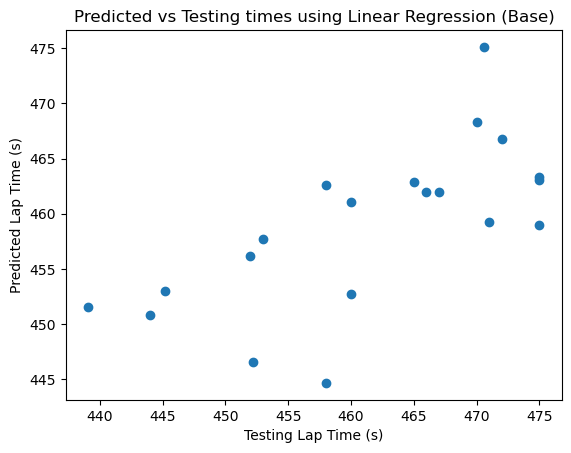

In [6]:
lr = linear_model.LinearRegression()
lr.fit(X_train, Y_train)
lrY_pred = lr.predict(X_test)
evalModel(lrY_pred, "Linear Regression (Base)")

## 1.1 Scaling

Mean squared error (MSE): 67.97
Coefficient of determination (R^2): 0.41


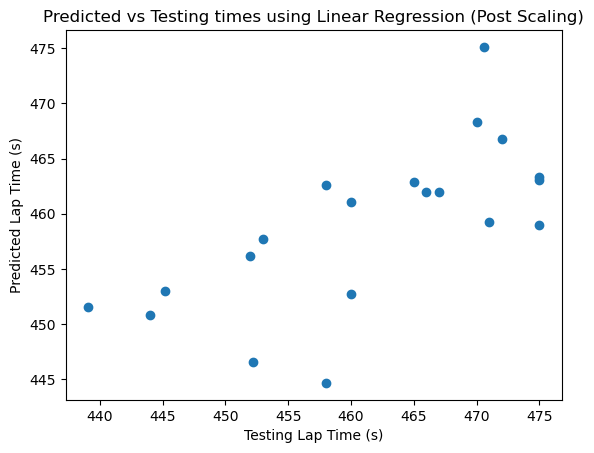

In [7]:
lr1 = linear_model.LinearRegression()
lr1.fit(Scaled_Xtrain, Y_train)
lrY_pred1 = lr1.predict(Scaled_Xtest)

evalModel(lrY_pred1,"Linear Regression (Post Scaling)")

## 1.2 Feature Selection

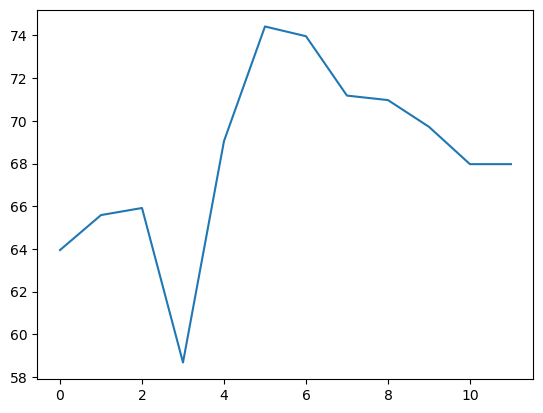

In [8]:
lr3 = linear_model.LinearRegression()
lr3Selection, bestParamslr = efficiencyGraph(linear_model.LinearRegression, X_train, X_test, False, "Linear Regression")

In [9]:
Selected_Xtrainlr = X_train[bestParamslr]
Selected_Xtestlr = X_test[bestParamslr]

In [10]:
scalerlr = StandardScaler()
scalerlr.fit(Selected_Xtrainlr)
ScaledSelectedLRtrain = scalerlr.transform(Selected_Xtrainlr)
ScaledSelectedLRtest = scalerlr.transform(Selected_Xtestlr)

Mean squared error (MSE): 58.68
Coefficient of determination (R^2): 0.49


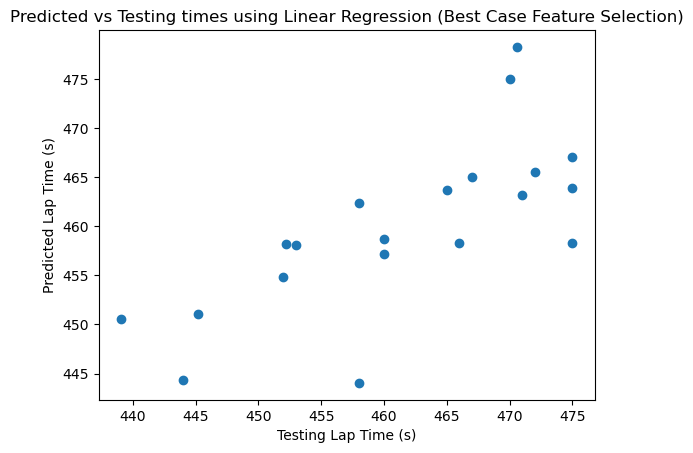

In [11]:
lr3comp = linear_model.LinearRegression()
lr3comp.fit(ScaledSelectedLRtrain, Y_train)
lrY_pred3 = lr3comp.predict(ScaledSelectedLRtest)
evalModel(lrY_pred3, "Linear Regression (Best Case Feature Selection)")

## 1.3 Grid Search CV Hyperparameter Selection

Mean squared error (MSE): 61.82
Coefficient of determination (R^2): 0.47


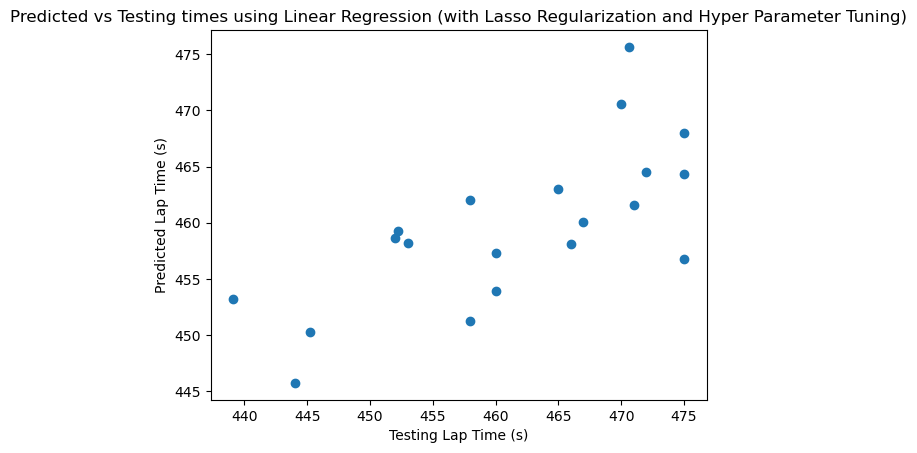

In [12]:
lr4 = linear_model.Lasso()

from sklearn.model_selection import RepeatedKFold


param_gridlr = {
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'fit_intercept':[True, False],
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

gslr = GridSearchCV(lr4, param_gridlr, scoring='neg_mean_squared_error', cv=cv)
gslr = gslr.fit(ScaledSelectedLRtrain, Y_train)

yhatmlLasso = gslr.predict(ScaledSelectedLRtest)
evalModel(yhatmlLasso, "Linear Regression (with Lasso Regularization and Hyper Parameter Tuning)")

Mean squared error (MSE): 58.55
Coefficient of determination (R^2): 0.49


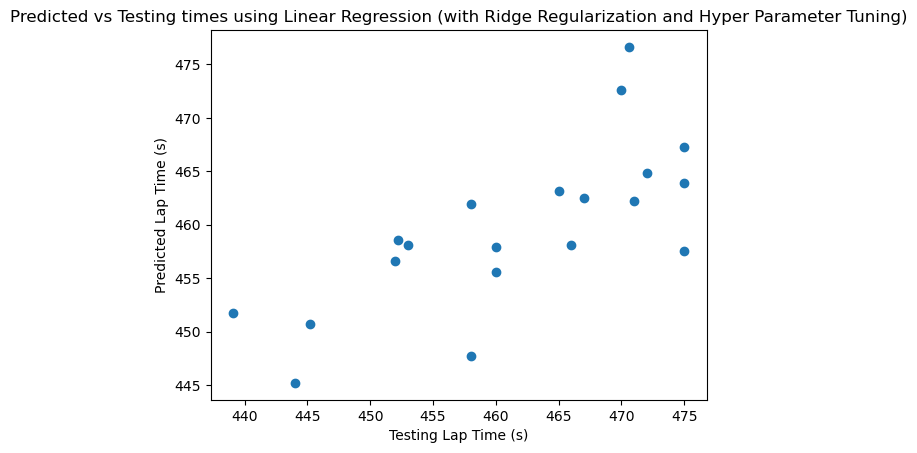

In [13]:
lr5 = linear_model.Ridge()

from sklearn.model_selection import RepeatedKFold


param_gridlrRidge = {
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'fit_intercept':[True, False],
}

cvRidge = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

gslrRidge = GridSearchCV(lr5, param_gridlrRidge, scoring='neg_mean_squared_error', cv=cvRidge)
gslrRidge = gslrRidge.fit(ScaledSelectedLRtrain, Y_train)

yhatmlRidge = gslrRidge.predict(ScaledSelectedLRtest)
evalModel(yhatmlRidge, "Linear Regression (with Ridge Regularization and Hyper Parameter Tuning)")

# 2. Gradient Boosted Trees

Mean squared error (MSE): 73.05
Coefficient of determination (R^2): 0.37


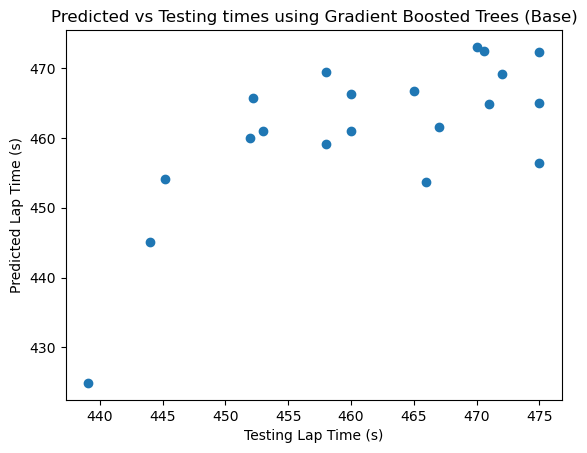

In [14]:
rng_seed = 425
gbr = GradientBoostingRegressor(random_state=rng_seed)
gbr.fit(X_train, Y_train)
gbrY_pred = gbr.predict(X_test)
evalModel(gbrY_pred, "Gradient Boosted Trees (Base)")

## 2.1 Scaling

Mean squared error (MSE): 73.05
Coefficient of determination (R^2): 0.37


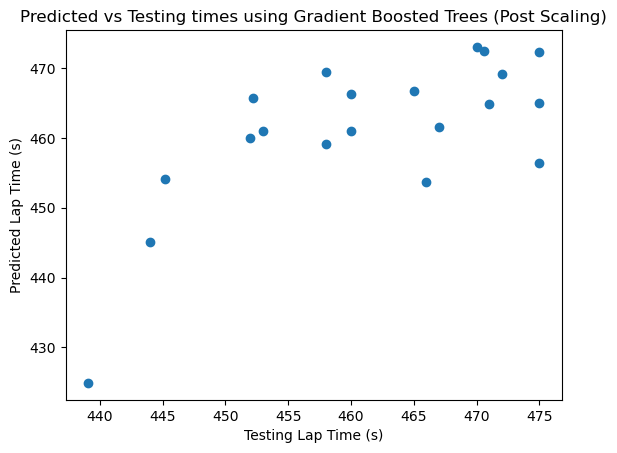

In [15]:
gbr2 = GradientBoostingRegressor(random_state=rng_seed)
gbr2.fit(Scaled_Xtrain, Y_train)
gbrY_pred2 = gbr2.predict(Scaled_Xtest)
evalModel(gbrY_pred2, "Gradient Boosted Trees (Post Scaling)")

## 2.2 Feature Selection

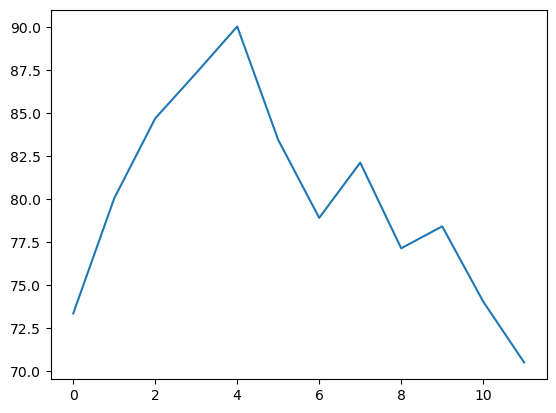

In [16]:
gbr3 = GradientBoostingRegressor(random_state=rng_seed)
gbr3Selection, bestParamsgbr = efficiencyGraph(GradientBoostingRegressor, X_train, X_test, False, "Gradient Boosted Trees")

In [17]:
Selected_Xtraingbr = X_train[bestParamsgbr]
Selected_Xtestgbr = X_test[bestParamsgbr]

In [18]:
scalerGBR = StandardScaler()
scalerGBR.fit(Selected_Xtraingbr)
ScaledSelectedGBRtrain = scalerGBR.transform(Selected_Xtraingbr)
ScaledSelectedGBRtest = scalerGBR.transform(Selected_Xtestgbr)

Mean squared error (MSE): 71.92
Coefficient of determination (R^2): 0.38


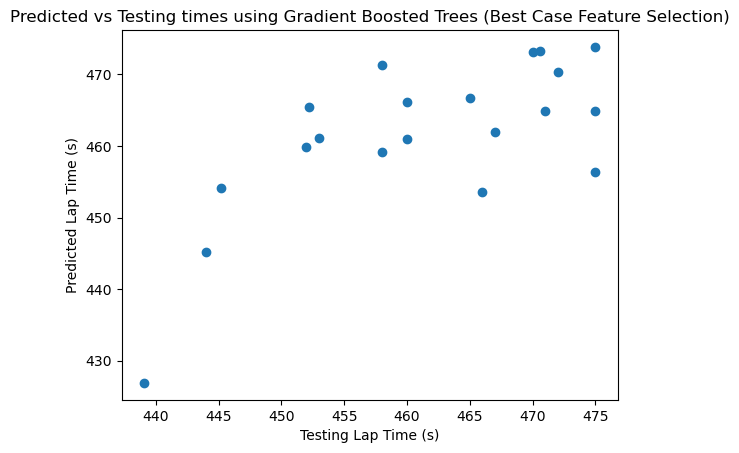

In [19]:
gbr3comp = GradientBoostingRegressor(random_state=rng_seed)
gbr3comp.fit(ScaledSelectedGBRtrain, Y_train)
gbr3pred = gbr3comp.predict(ScaledSelectedGBRtest)
evalModel(gbr3pred, "Gradient Boosted Trees (Best Case Feature Selection)")

## 2.3 Grid Search Cross Validation

C:\Users\jiand\anaconda3\envs\sdse\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jiand\anaconda3\envs\sdse\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jiand\anaconda3\envs\sdse\lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self._validate_params()
  File "C:\Users\jiand\anaconda3\envs\sdse\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "C:

(80, 12) (20, 12)
Mean squared error (MSE): 58.69
Coefficient of determination (R^2): 0.49


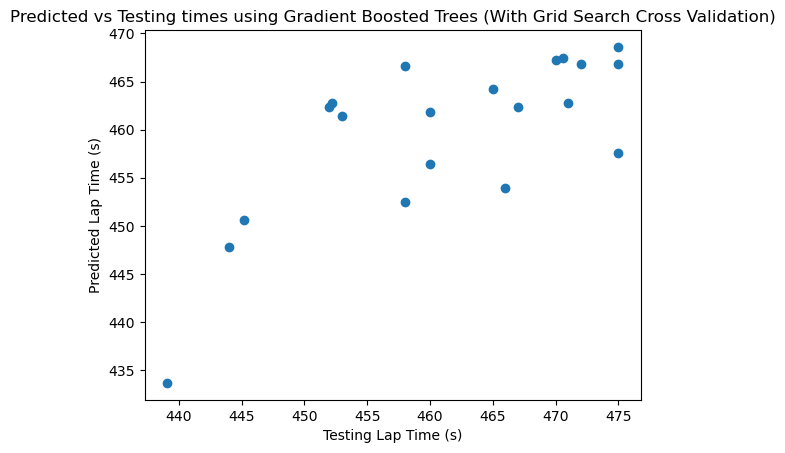

In [20]:
from sklearn.model_selection import RepeatedKFold

gbr4 = GradientBoostingRegressor(random_state=rng_seed)

param_gridgbr = {
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    "max_leaf_nodes" : [2, 4, 8, 16],
#     "learning_rate" : [0.1, 0.2, 0.4, 1]
}

cvgbr = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

gsgbr = GridSearchCV(gbr4, param_gridgbr, scoring='neg_mean_squared_error', cv=cvgbr)
gsgbr = gsgbr.fit(ScaledSelectedGBRtrain, Y_train)

print(ScaledSelectedGBRtrain.shape, ScaledSelectedGBRtest.shape)
yhatgbr = gsgbr.predict(ScaledSelectedGBRtest)
evalModel(yhatgbr, "Gradient Boosted Trees (With Grid Search Cross Validation)")

### 3. Support Vector Regression

Mean squared error (MSE): 114.50
Coefficient of determination (R^2): 0.01


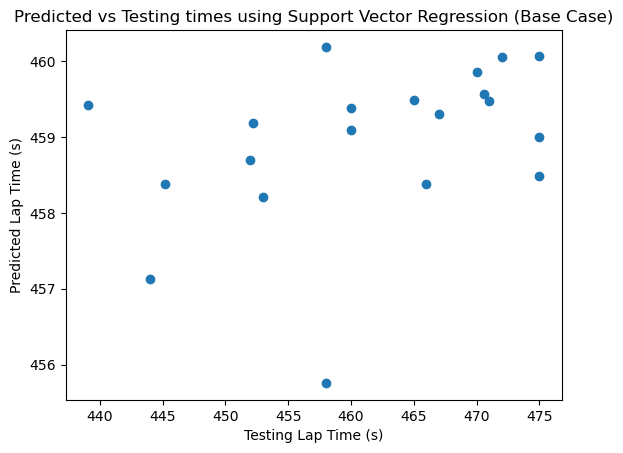

In [21]:
svr = SVR()
svr.fit(X_train, Y_train)
svrY_pred = svr.predict(X_test)
evalModel(svrY_pred, "Support Vector Regression (Base Case)")

## 3.1 Scaling

Mean squared error (MSE): 95.38
Coefficient of determination (R^2): 0.18


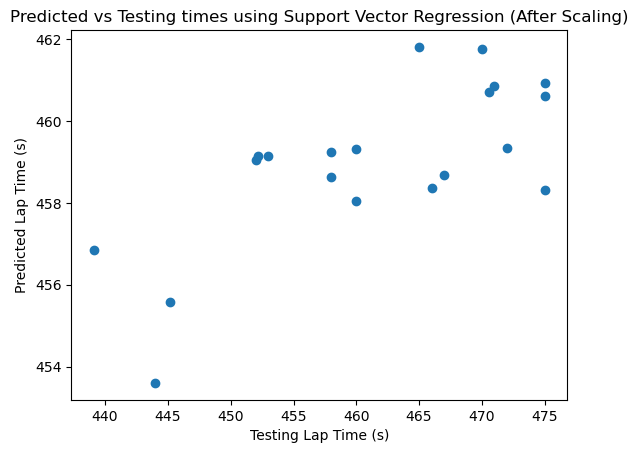

In [22]:
svr1 = SVR()
svr1.fit(Scaled_Xtrain, Y_train)
svrY_pred1 = svr1.predict(Scaled_Xtest)
evalModel(svrY_pred1, "Support Vector Regression (After Scaling)")

## 3.2 Feature Selection

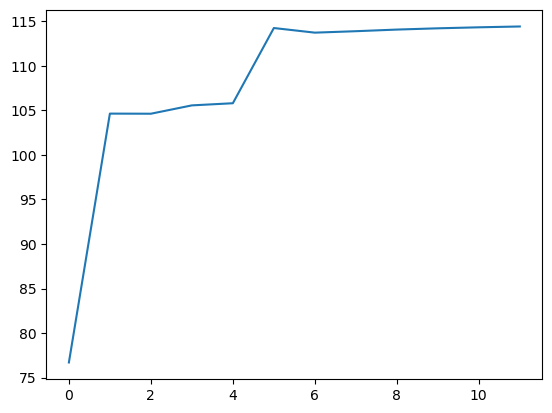

In [23]:
svr2 = SVR()
svr2Selection, bestParamsSVR = efficiencyGraph(SVR, X_train, X_test, False, "Support Vector Regression")

In [24]:
Selected_XtrainSVR = X_train[bestParamsSVR]
print(Selected_XtrainSVR)
Selected_XtestSVR = X_test[bestParamsSVR]

    0-60 (s)
56     2.800
86     3.700
58     3.700
14     3.600
71     3.900
..       ...
76     3.900
96     3.800
82     4.100
99     3.900
13     2.897

[80 rows x 1 columns]


In [25]:
scalerSVR = StandardScaler()
scalerSVR.fit(Selected_XtrainSVR)
ScaledSelectedSVRtrain = scalerSVR.transform(Selected_XtrainSVR)
ScaledSelectedSVRtest = scalerSVR.transform(Selected_XtestSVR)

Mean squared error (MSE): 76.70
Coefficient of determination (R^2): 0.34


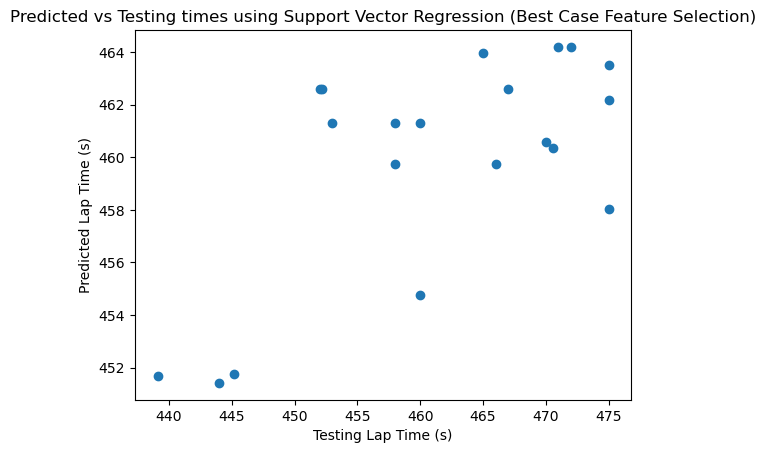

In [26]:
SVRcomp = SVR()
SVRcomp.fit(ScaledSelectedSVRtrain, Y_train)
SVRpred = SVRcomp.predict(ScaledSelectedSVRtest)
evalModel(SVRpred, "Support Vector Regression (Best Case Feature Selection)")

## 3.3 Grid Search Cross Validation

Mean squared error (MSE): 63.78
Coefficient of determination (R^2): 0.45


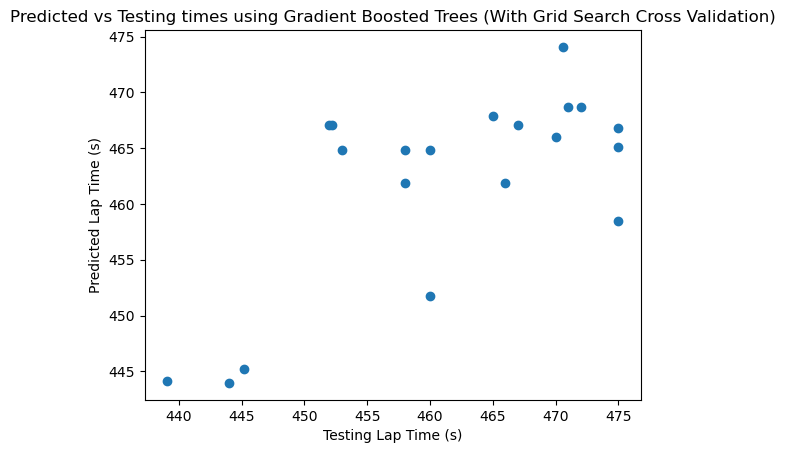

In [27]:
from sklearn.model_selection import RepeatedKFold

SVR4 = SVR()

param_gridSVR = {
    'C' : [1,5,10,20],
    'degree' : [3,8,12],
}

cvSVR = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

gsSVR = GridSearchCV(SVR4, param_gridSVR, scoring='neg_mean_squared_error', cv=cvSVR)
gsSVR = gsSVR.fit(ScaledSelectedSVRtrain, Y_train)

yhatSVR = gsSVR.predict(ScaledSelectedSVRtest)
evalModel(yhatSVR, "Gradient Boosted Trees (With Grid Search Cross Validation)")